In [142]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langchain_community tavily-python langgraph-checkpoint-sqlite wikipedia

In [5]:
from dotenv import load_dotenv
load_dotenv()

True

# Basics

In [3]:
from langchain_openai import ChatOpenAI
gpt4o_chat = ChatOpenAI(model="gpt-4o", temperature=0)
gpt35_chat = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

/Users/rohitkumar/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
from langchain_core.messages import HumanMessage

# Create a message
msg = HumanMessage(content="Hello world", name="Lance")

# Message list
messages = [msg]

# Invoke the model with a list of messages 
gpt4o_chat.invoke(messages)

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 11, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_46bff0e0c8', 'id': 'chatcmpl-CAmLXOBDy95huCIXW95JHOKVMJM1b', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--48ec4ecf-d907-4044-b5f1-78c98ef263a0-0', usage_metadata={'input_tokens': 11, 'output_tokens': 9, 'total_tokens': 20, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [6]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)
search_docs = tavily_search.invoke("What is LangGraph?")

/var/folders/xm/hv0x78kx5mvbzd2tsn4q98km0000gn/T/ipykernel_70189/3227139208.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(max_results=3)


In [7]:
search_docs

[{'title': 'What is LangGraph? - IBM',
  'url': 'https://www.ibm.com/think/topics/langgraph',
  'content': 'LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. It provides a set of tools and libraries that enable users to create, run and optimize large language models (LLMs) in a scalable and efficient manner. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. [...] Agent systems: LangGraph provides a framework for building agent-based systems, which can be used in applications such as robotics, autonomous vehicles or video games.\n\nLLM applications: By using LangGraph’s capabilities, developers can build more sophisticated AI models that learn and improve over time. Norwegian Cruise Line uses LangGraph to compile, construct and refine guest-facing AI solutions. This capability 

# Simple-Graph

## State

In [8]:
from typing_extensions import TypedDict

class State(TypedDict):
    graph_state: str

## Node

In [9]:
def node_1(state):
    print("---Node 1---")
    return {"graph_state": state['graph_state'] +" I am"}

def node_2(state):
    print("---Node 2---")
    return {"graph_state": state['graph_state'] +" happy!"}

def node_3(state):
    print("---Node 3---")
    return {"graph_state": state['graph_state'] +" sad!"}

## Edge

In [10]:
import random
from typing import Literal

def decide_mood(state) -> Literal["node_2", "node_3"]:
    
    # Often, we will use state to decide on the next node to visit
    user_input = state['graph_state'] 
    
    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"
    
    # 50% of the time, we return Node 3
    return "node_3"

## Graph Construction

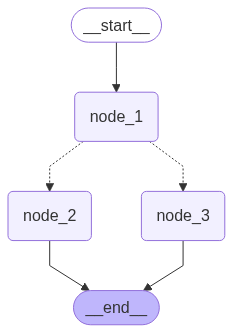

In [11]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## Graph Invoke

In [12]:
graph.invoke({"graph_state" : "Hi, this is Lance."})

---Node 1---
---Node 3---


{'graph_state': 'Hi, this is Lance. I am sad!'}

# Chain

## Messages

In [13]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


## Tools

In [14]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
llm_with_tools = llm.bind_tools([multiply])

In [15]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])

In [16]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_mR4NSLIzhxRf082GYwX8TU5a',
  'type': 'tool_call'}]

## Reducers

In [18]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

In [ ]:
# Reducers
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [20]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

In [21]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='5b5d6119-a8cf-4fae-bf36-0ed383dffcab'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='9c9ec5de-2501-49e7-836e-6f2248ed6cf2'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='54963398-6f56-4f4f-863d-74a1767a326b')]

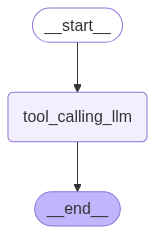

In [22]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I assist you today?


In [24]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_IRJfOsgKpXJncu0JLyoGDo59)
 Call ID: call_IRJfOsgKpXJncu0JLyoGDo59
  Args:
    a: 2
    b: 3


# Router

In [ ]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools([multiply])

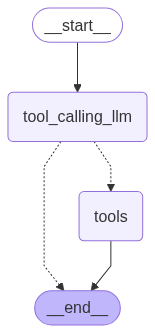

In [25]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Hello, what is 2 multiplied by 2?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, what is 2 multiplied by 2?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_xjF9epHHGfS19XfhPYhLGl51)
 Call ID: call_xjF9epHHGfS19XfhPYhLGl51
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: multiply

4


# Agent

In [27]:
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [28]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")

# For this ipynb we set parallel tool calling to false as math generally is done sequentially, and this time we have 3 tools that can do math
# the OpenAI model specifically defaults to parallel tool calling for efficiency, see https://python.langchain.com/docs/how_to/tool_calling_parallel/
# play around with it and see how the model behaves with math equations!
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

In [29]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

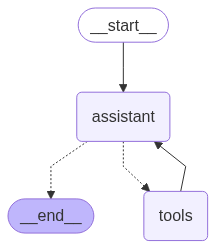

In [30]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [31]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})

In [32]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_lF2Yf66xR4N9DFCO66taETel)
 Call ID: call_lF2Yf66xR4N9DFCO66taETel
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_haYAb4khVvbvjkE97k4FMqGQ)
 Call ID: call_haYAb4khVvbvjkE97k4FMqGQ
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (call_escBXd3lBMUhGaMEfyJyAkHl)
 Call ID: call_escBXd3lBMUhGaMEfyJyAkHl
  Args:
    a: 14
    b: 5
================================= Tool Message ===============

# Agent with memory

In [33]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

In [34]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_RKEWPMnCOGah82RkC2iV6TUU)
 Call ID: call_RKEWPMnCOGah82RkC2iV6TUU
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [35]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_RKEWPMnCOGah82RkC2iV6TUU)
 Call ID: call_RKEWPMnCOGah82RkC2iV6TUU
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_Jy5b8ZTYaKbCFJL7mY4Zb8AL)
 Call ID: call_Jy5b8ZTYaKbCFJL7mY4Zb8AL
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

The result of multipl

# State Schema

## TypeDict

In [1]:
from typing_extensions import TypedDict

class TypedDictState(TypedDict):
    foo: str
    bar: str

In [2]:
from typing import Literal

class TypedDictState(TypedDict):
    name: str
    mood: Literal["happy","sad"]

/Users/rohitkumar/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


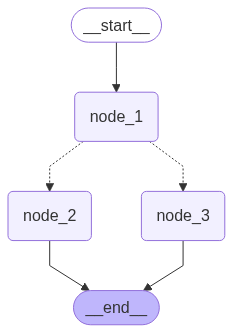

In [3]:
import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

def node_1(state):
    print("---Node 1---")
    return {"name": state['name'] + " is ... "}

def node_2(state):
    print("---Node 2---")
    return {"mood": "happy"}

def node_3(state):
    print("---Node 3---")
    return {"mood": "sad"}

def decide_mood(state) -> Literal["node_2", "node_3"]:
        
    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"
    
    # 50% of the time, we return Node 3
    return "node_3"

# Build graph
builder = StateGraph(TypedDictState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
graph.invoke({"name":"Lance"})

---Node 1---
---Node 2---


{'name': 'Lance is ... ', 'mood': 'happy'}

## Dataclass

In [5]:
from dataclasses import dataclass

@dataclass
class DataclassState:
    name: str
    mood: Literal["happy","sad"]

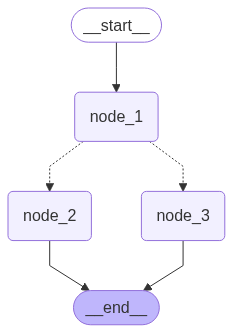

In [6]:
def node_1(state):
    print("---Node 1---")
    return {"name": state.name + " is ... "}

# Build graph
builder = StateGraph(DataclassState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
graph.invoke(DataclassState(name="Lance",mood="sad"))

---Node 1---
---Node 2---


{'name': 'Lance is ... ', 'mood': 'happy'}

In [8]:
dataclass_instance = DataclassState(name="Lance", mood="mad")

## PyDantic

In [9]:
from pydantic import BaseModel, field_validator, ValidationError

class PydanticState(BaseModel):
    name: str
    mood: str # "happy" or "sad" 

    @field_validator('mood')
    @classmethod
    def validate_mood(cls, value):
        # Ensure the mood is either "happy" or "sad"
        if value not in ["happy", "sad"]:
            raise ValueError("Each mood must be either 'happy' or 'sad'")
        return value

try:
    state = PydanticState(name="John Doe", mood="mad")
except ValidationError as e:
    print("Validation Error:", e)

Validation Error: 1 validation error for PydanticState
mood
  Value error, Each mood must be either 'happy' or 'sad' [type=value_error, input_value='mad', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/value_error


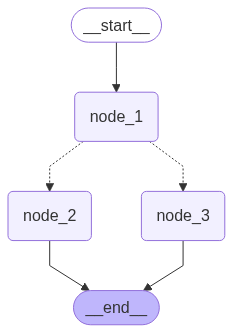

In [10]:
# Build graph
builder = StateGraph(PydanticState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
graph.invoke(PydanticState(name="Lance",mood="sad"))

---Node 1---
---Node 2---


{'name': 'Lance is ... ', 'mood': 'happy'}

# State Reducers

## Default overwriting state

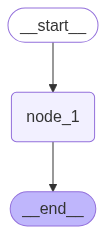

In [12]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
graph.invoke({"foo" : 1})

---Node 1---


{'foo': 2}

## Branching

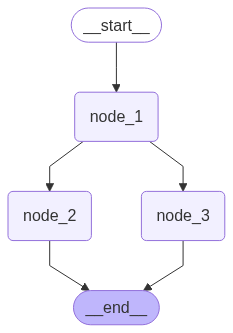

In [14]:
class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

def node_2(state):
    print("---Node 2---")
    return {"foo": state['foo'] + 1}

def node_3(state):
    print("---Node 3---")
    return {"foo": state['foo'] + 1}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"foo" : 1})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError occurred: {e}")


---Node 1---
---Node 3---
---Node 2---
InvalidUpdateError occurred: At key 'foo': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


## Reducers

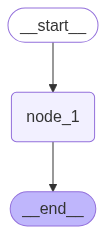

In [16]:
from operator import add
from typing import Annotated

class State(TypedDict):
    foo: Annotated[list[int], add]

def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][0] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
graph.invoke({"foo" : [1]})

---Node 1---


{'foo': [1, 2]}

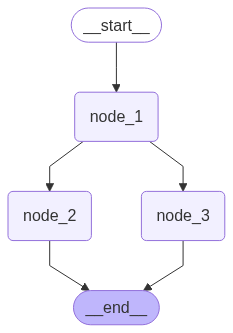

In [18]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][-1] + 1]}

def node_2(state):
    print("---Node 2---")
    return {"foo": [state['foo'][-1] + 1]}

def node_3(state):
    print("---Node 3---")
    return {"foo": [state['foo'][-1] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
graph.invoke({"foo" : [1]})

---Node 1---
---Node 2---
---Node 3---


{'foo': [1, 2, 3, 3]}

In [20]:
try:
    graph.invoke({"foo" : None})
except TypeError as e:
    print(f"TypeError occurred: {e}")

TypeError occurred: can only concatenate list (not "NoneType") to list


## Custom Reducers

In [23]:
from typing import Union
def reduce_list(left: Union[list, None], right: Union[list, None]) -> list:
    """Safely combine two lists, handling cases where either or both inputs might be None.

    Args:
        left (list | None): The first list to combine, or None.
        right (list | None): The second list to combine, or None.

    Returns:
        list: A new list containing all elements from both input lists.
               If an input is None, it's treated as an empty list.
    """
    if not left:
        left = []
    if not right:
        right = []
    return left + right

class DefaultState(TypedDict):
    foo: Annotated[list[int], add]

class CustomReducerState(TypedDict):
    foo: Annotated[list[int], reduce_list]

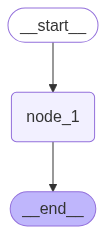

TypeError occurred: can only concatenate list (not "NoneType") to list


In [24]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [2]}

# Build graph
builder = StateGraph(DefaultState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

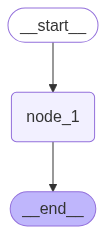

---Node 1---
{'foo': [2]}


In [25]:
# Build graph
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

## Messages

In [26]:
from typing import Annotated
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

# Define a custom TypedDict that includes a list of messages with add_messages reducer
class CustomMessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    added_key_1: str
    added_key_2: str
    # etc

# Use MessagesState, which includes the messages key with add_messages reducer
class ExtendedMessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    added_key_1: str
    added_key_2: str
    # etc

In [27]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='45277698-45a9-4a69-beec-5dbdbefa0712'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='80e7a23b-2e0e-4454-ab43-46faff7609bc'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='d2d22d93-2f81-4832-9694-293cf59f4b29')]

## Re-writing

In [28]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model", id="1"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance", id="2")
                   ]

# New message to add
new_message = HumanMessage(content="I'm looking for information on whales, specifically", name="Lance", id="2")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='1'),
 HumanMessage(content="I'm looking for information on whales, specifically", additional_kwargs={}, response_metadata={}, name='Lance', id='2')]

## Removal

In [29]:
from langchain_core.messages import RemoveMessage

# Message list
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Isolate messages to delete
delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]
print(delete_messages)

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2')]


In [30]:
add_messages(messages , delete_messages)

[AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4')]

## Multiple Schema

## Private Schema

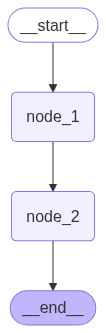

In [32]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class OverallState(TypedDict):
    foo: int

class PrivateState(TypedDict):
    baz: int

def node_1(state: OverallState) -> PrivateState:
    print("---Node 1---")
    return {"baz": state['foo'] + 1}

def node_2(state: PrivateState) -> OverallState:
    print("---Node 2---")
    return {"foo": state['baz'] + 1}

# Build graph
builder = StateGraph(OverallState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
graph.invoke({"foo" : 1})

---Node 1---
---Node 2---


{'foo': 3}

## Input/Output Schema

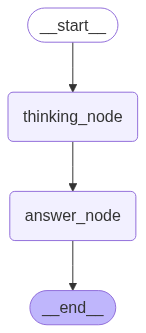

In [34]:
class OverallState(TypedDict):
    question: str
    answer: str
    notes: str

def thinking_node(state: OverallState):
    return {"answer": "bye", "notes": "... his name is Lance"}

def answer_node(state: OverallState):
    return {"answer": "bye Lance"}

graph = StateGraph(OverallState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [35]:
graph.invoke({"question":"hi"})

{'question': 'hi', 'answer': 'bye Lance', 'notes': '... his name is Lance'}

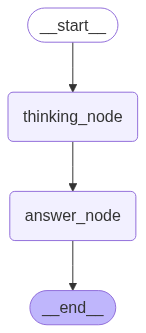

{'answer': 'bye Lance'}

In [36]:
class InputState(TypedDict):
    question: str

class OutputState(TypedDict):
    answer: str

class OverallState(TypedDict):
    question: str
    answer: str
    notes: str

def thinking_node(state: InputState):
    return {"answer": "bye", "notes": "... his is name is Lance"}

def answer_node(state: OverallState) -> OutputState:
    return {"answer": "bye Lance"}

graph = StateGraph(OverallState, input_schema=InputState, output_schema=OutputState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"question":"hi"})

# Trim and Filter Messages

In [38]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


In [39]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
llm.invoke(messages)

AIMessage(content='In addition to whales, several other fascinating ocean mammals are worth learning about:\n\n1. **Dolphins**: Known for their intelligence and playful behavior, dolphins are part of the cetacean family, which also includes whales and porpoises. There are about 40 species of dolphins, including the well-known bottlenose dolphin.\n\n2. **Porpoises**: Often confused with dolphins, porpoises are smaller and have different physical features, such as shorter snouts and spade-shaped teeth. There are seven species of porpoises.\n\n3. **Seals**: These pinnipeds include a variety of species such as harbor seals, gray seals, and elephant seals. They are adapted to live both in water and on land, often seen lounging on beaches or ice.\n\n4. **Sea Lions**: Related to seals, sea lions are also pinnipeds but are typically larger and known for their loud barking. They have external ear flaps, unlike true seals.\n\n5. **Walruses**: Recognizable by their long tusks and whiskers, walrus

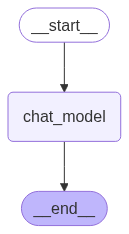

In [40]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [41]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several fascinating ocean mammals that you might want to learn about:

1. **Dolphins**: Intelligent and social creatures, dolphins are known for their playful behavior and complex communication. They belong to the same family as whales, called cetaceans.

2. **Porpoises**: Similar to dolphins but generally smaller, porpoises also belong to the cetacean family. They have shorter snouts and are typically more shy and reclusive.

3. **Seals**: These semi-aquatic marine mammals are part of the pinniped family. They are adapted to both land and sea and are known for their thick fur and

## Reducers

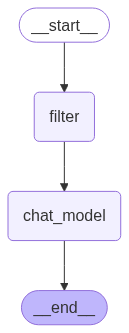

In [42]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [43]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Aside from whales, there are a variety of fascinating ocean mammals you might explore:

1. **Dolphins**: Known for their intelligence and playful behavior, dolphins are found in oceans worldwide and are closely related to whales.

2. **Porpoises**: They are similar to dolphins but generally smaller and less social, with different facial structures and teeth.

3. **Seals**: These pinnipeds have adapted to life in the water with streamlined bodies and flippers while maintaining the ability to come onto land.

4. **Sea Lions**: Often confused with seals, sea lions are more vocal and have external ear flaps.

5. **Wa

## Filter Messages

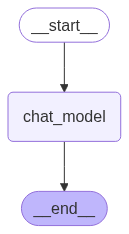

In [44]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [45]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [46]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Aside from whales, there are a variety of fascinating ocean mammals you might explore:

1. **Dolphins**: Known for their intelligence and playful behavior, dolphins are found in oceans worldwide and are closely related to whales.

2. **Porpoises**: They are similar to dolphins but generally smaller and less social, with different facial structures and teeth.

3. **Seals**: These pinnipeds have adapted to life in the water 

In [47]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Aside from whales, there are a variety of fascinating ocean mammals you might explore:

1. **Dolphins**: Known for their intelligence and playful behavior, dolphins are found in oceans worldwide and are closely related to whales.

2. **Porpoises**: They are similar to dolphins but generally smaller and less social, with different facial structures and teeth.

3. **Seals**: These pinnipeds have adapted to life in the water 

## Trim Messages

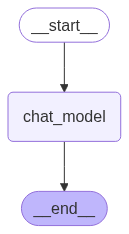

In [48]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [49]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [50]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )

[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [51]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

In [52]:
messages_out_trim

{'messages': [AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
  HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Lance', id='2'),
  AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
  HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4'),
  AIMessage(content='Aside from whales, there are a variety of fascinating ocean mammals you might explore:\n\n1. **Dolphins**: Known for their intelligence and playful behavior, dolphins are found in oceans worldwide and are closely related to whales.\n\n2. **Porpoises**: They are similar to dolphins but generally smaller and less social, with different facial structures and teeth.\n\n3. **Seals**: These pinnipeds have adapted to life in the water with streamlined bodies and flippers while maintainin

# Chat w/ Summarizing Messages and Memory

In [53]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o",temperature=0)

In [54]:
from langgraph.graph import MessagesState
class State(MessagesState):
    summary: str

In [55]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

In [56]:
def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

In [57]:
from langgraph.graph import END
from typing_extensions import Literal
# Determine whether to end or summarize the conversation
def should_continue(state: State) -> Literal ["summarize_conversation",END]:
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

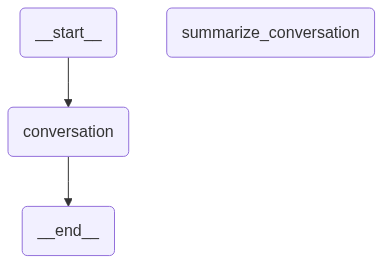

In [58]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [59]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hello Lance! How can I assist you today?
================================== Ai Message ==================================

You mentioned that your name is Lance. How can I help you today?
================================== Ai Message ==================================

That's great! The San Francisco 49ers have a rich history and a passionate fan base. Do you have a favorite player or a memorable game that you particularly enjoyed?


In [60]:
graph.get_state(config).values.get("summary","")

''

In [61]:
input_message = HumanMessage(content="i like Nick Bosa, isn't he the highest paid defensive player?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Yes, as of September 2023, Nick Bosa became the highest-paid defensive player in NFL history. He signed a five-year contract extension with the San Francisco 49ers worth $170 million, with $122.5 million guaranteed. Bosa is known for his exceptional skills as a defensive end and has been a key player for the 49ers.


In [62]:
graph.get_state(config).values.get("summary","")

'Lance introduced himself and expressed his support for the San Francisco 49ers, mentioning a particular liking for Nick Bosa. The conversation highlighted that Nick Bosa became the highest-paid defensive player in NFL history as of September 2023, with a significant contract extension with the 49ers.'

# Chatbot w/ Summarizing Messages and External Memory

In [63]:
import sqlite3
# In memory
conn = sqlite3.connect(":memory:", check_same_thread = False)

In [64]:
# pull file if it doesn't exist and connect to local db
!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

--2025-09-01 07:22:36--  https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db
Resolving github.com (github.com)... 64:ff9b::14cf:4952, 20.207.73.82
Connecting to github.com (github.com)|64:ff9b::14cf:4952|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/langchain-ai/langchain-academy/main/module-2/state_db/example.db [following]
--2025-09-01 07:22:37--  https://raw.githubusercontent.com/langchain-ai/langchain-academy/main/module-2/state_db/example.db
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8003::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110592 (108K) [application/octet-stream]
Saving to: ‘state_db/example.db’

example.db          100%[===================>] 108.00K  --.-KB/s    in 0.1s

In [67]:
# Here is our checkpointer 
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

In [68]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState

model = ChatOpenAI(model="gpt-4o",temperature=0)

class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

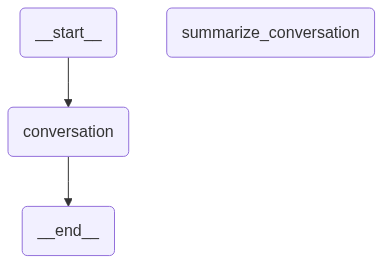

In [69]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [70]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hi Lance! It's great to hear from you again. If there's anything specific you'd like to discuss or any questions you have, feel free to let me know!
================================== Ai Message ==================================

Your name is Lance! If there's anything else you'd like to talk about or any questions you have, just let me know.
================================== Ai Message ==================================

That's awesome! The San Francisco 49ers have a rich history and a passionate fan base. Is there anything specific about the 49ers you'd like to discuss, like their current season, players, or memorable games?


In [71]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='db243d93-60c4-4da7-a3c0-fd759a32047e'), AIMessage(content="Hi Lance! It's great to hear from you again. If there's anything specific you'd like to discuss or any questions you have, feel free to let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 337, 'total_tokens': 369, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_46bff0e0c8', 'id': 'chatcmpl-CAo2M1zjripfSTJRkE2fjIq9PX6Vj', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--c495c6c8-82ea-4a6d-9017-f03ddff00969-0', usage_metadata={'input_tokens': 337, 'output_tokens': 32, 'total_tokens': 369, '

## Persisting State

In [72]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='db243d93-60c4-4da7-a3c0-fd759a32047e'), AIMessage(content="Hi Lance! It's great to hear from you again. If there's anything specific you'd like to discuss or any questions you have, feel free to let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 337, 'total_tokens': 369, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_46bff0e0c8', 'id': 'chatcmpl-CAo2M1zjripfSTJRkE2fjIq9PX6Vj', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--c495c6c8-82ea-4a6d-9017-f03ddff00969-0', usage_metadata={'input_tokens': 337, 'output_tokens': 32, 'total_tokens': 369, '

# Streaming

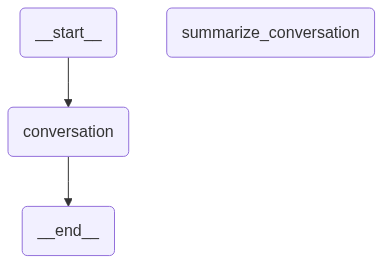

In [73]:
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0) 

# State 
class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State, config: RunnableConfig):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## Streaming Full State

In [74]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content='Hello Lance! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 11, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ff25b2783a', 'id': 'chatcmpl-CAoDisfUx7ZQc1VkCpC7UcvYX4y4g', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--9be2e403-bc9b-4cf2-a080-1e515ccdf2af-0', usage_metadata={'input_tokens': 11, 'output_tokens': 10, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}}


In [75]:
# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

Hi Lance! How's it going? What can I do for you today?


In [76]:
# Start conversation, again
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

hi! I'm Lance
---------------------------------------------------------------------------
================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hello, Lance! How can I assist you today?
---------------------------------------------------------------------------


In [77]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. N

In [78]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run--db6b9ca6-ca5e-4a50-b9bf-32498a54114b')}
{'chunk': AIMessageChunk(content='The', additional_kwargs={}, response_metadata={}, id='run--db6b9ca6-ca5e-4a50-b9bf-32498a54114b')}
{'chunk': AIMessageChunk(content=' San', additional_kwargs={}, response_metadata={}, id='run--db6b9ca6-ca5e-4a50-b9bf-32498a54114b')}
{'chunk': AIMessageChunk(content=' Francisco', additional_kwargs={}, response_metadata={}, id='run--db6b9ca6-ca5e-4a50-b9bf-32498a54114b')}
{'chunk': AIMessageChunk(content=' ', additional_kwargs={}, response_metadata={}, id='run--db6b9ca6-ca5e-4a50-b9bf-32498a54114b')}
{'chunk': AIMessageChunk(content='49', additional_kwargs={}, response_metadata={}, id='run--db6b9ca6-ca5e-4a50-b9bf-32498a54114b')}
{'chunk': AIMessageChunk(content='ers', additional_kwargs={}, response_metadata={}, id='run--db6b9ca6-ca5e-4a50-b9bf-32498a54114b')}
{'chunk': AIMessageChunk(content=' are', additional_kwargs={}, resp

In [79]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

|The| San| Francisco| |49|ers| are| a| professional| American| football| team| based| in| the| San| Francisco| Bay| Area|.| They| compete| in| the| National| Football| League| (|NFL|)| as| a| member| of| the| league|'s| National| Football| Conference| (|N|FC|)| West| division|.| The| team| was| founded| in| |194|6| as| a| charter| member| of| the| All|-Amer|ica| Football| Conference| (|AA|FC|)| and| joined| the| NFL| in| |194|9| when| the| leagues| merged|.

|###| Key| Points|:

|-| **|St|adium|**|:| The| |49|ers| play| their| home| games| at| Levi|'s| Stadium| in| Santa| Clara|,| California|,| which| they| moved| to| in| |201|4|.| Before| that|,| they| played| at| Cand|lestick| Park| in| San| Francisco|.

|-| **|Team| Colors|**|:| The| team's| colors| are| red|,| gold|,| and| white|.

|-| **|Masc|ot|**|:| The| |49|ers|'| mascot| is| S|ourd|ough| Sam|.

|-| **|Champ|ionship|s|**|:| The| |49|ers| have| won| five| Super| Bowl| titles| (|X|VI|,| XIX|,| XX|III|,| XX|IV|,| and| XX|IX|),| wi

In [80]:
from langgraph_sdk import get_client

# This is the URL of the local development server
URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

In [81]:
# Create a new thread
thread = await client.threads.create()
# Input message
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="values"):
    print(event)

StreamPart(event='metadata', data={'run_id': '01990308-2e14-70e6-a7e9-e56a61548376', 'attempt': 1})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '77737bc9-7c62-4a5a-970e-2284fbbe0a14', 'example': False}]})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '77737bc9-7c62-4a5a-970e-2284fbbe0a14', 'example': False}, {'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_djkQi1mUAvibtMaEUrRmHcWh', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_

In [82]:
from langchain_core.messages import convert_to_messages
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], assistant_id="agent", input={"messages": [input_message]}, stream_mode="values"):
    messages = event.data.get('messages',None)
    if messages:
        print(convert_to_messages(messages)[-1])
    print('='*25)

content='Multiply 2 and 3' additional_kwargs={} response_metadata={} id='9d28b745-5d71-49f0-8731-cf07f41ae60d'
content='' additional_kwargs={'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 134, 'output_tokens': 17, 'total_tokens': 151, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}, 'tool_calls': [{'id': 'call_SFAs4GOFjbHxjQrF3JShCKgW', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_46bff0e0c8', 'id': 'chatcmpl-CAoGbVGJlwNvLrwdIh78NBi0qehnK', 'service_tier': 'default', 'finish_reason': 'tool_cal

In [83]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="messages"):
    print(event.event)

metadata
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/metadata
messages/complete
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial


In [84]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")

def format_tool_calls(tool_calls):
    """
    Format a list of tool calls into a readable string.

    Args:
        tool_calls (list): A list of dictionaries, each representing a tool call.
            Each dictionary should have 'id', 'name', and 'args' keys.

    Returns:
        str: A formatted string of tool calls, or "No tool calls" if the list is empty.

    """

    if tool_calls:
        formatted_calls = []
        for call in tool_calls:
            formatted_calls.append(
                f"Tool Call ID: {call['id']}, Function: {call['name']}, Arguments: {call['args']}"
            )
        return "\n".join(formatted_calls)
    return "No tool calls"

async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={"messages": [input_message]},
    stream_mode="messages",):
    
    # Handle metadata events
    if event.event == "metadata":
        print(f"Metadata: Run ID - {event.data['run_id']}")
        print("-" * 50)
    
    # Handle partial message events
    elif event.event == "messages/partial":
        for data_item in event.data:
            # Process user messages
            if "role" in data_item and data_item["role"] == "user":
                print(f"Human: {data_item['content']}")
            else:
                # Extract relevant data from the event
                tool_calls = data_item.get("tool_calls", [])
                invalid_tool_calls = data_item.get("invalid_tool_calls", [])
                content = data_item.get("content", "")
                response_metadata = data_item.get("response_metadata", {})

                if content:
                    print(f"AI: {content}")

                if tool_calls:
                    print("Tool Calls:")
                    print(format_tool_calls(tool_calls))

                if invalid_tool_calls:
                    print("Invalid Tool Calls:")
                    print(format_tool_calls(invalid_tool_calls))

                if response_metadata:
                    finish_reason = response_metadata.get("finish_reason", "N/A")
                    print(f"Response Metadata: Finish Reason - {finish_reason}")
                    
        print("-" * 50)

Metadata: Run ID - 01990309-3974-7742-bb59-a211a86c68a3
--------------------------------------------------
Tool Calls:
Tool Call ID: call_yHRk4cNezx8uufLZMwW4nTMa, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_yHRk4cNezx8uufLZMwW4nTMa, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_yHRk4cNezx8uufLZMwW4nTMa, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_yHRk4cNezx8uufLZMwW4nTMa, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_yHRk4cNezx8uufLZMwW4nTMa, Function: multiply, Arguments: {'a': 2}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_yHRk4cNezx8uufLZMwW4nTMa, Function: multiply, Arguments: {'a': 2}
--------------------------------------------------
Tool Calls:
Tool Call ID: cal

# Breakpoint

## Breakpoint for human approval

In [85]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

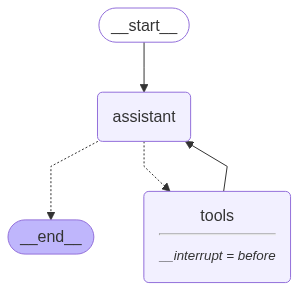

In [86]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [87]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_sb33zlSvrgBQhnLkXtrB5iKk)
 Call ID: call_sb33zlSvrgBQhnLkXtrB5iKk
  Args:
    a: 2
    b: 3


In [88]:
state = graph.get_state(thread)
state.next

('tools',)

In [89]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_sb33zlSvrgBQhnLkXtrB5iKk)
 Call ID: call_sb33zlSvrgBQhnLkXtrB5iKk
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


In [90]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":
    
    # If approved, continue the graph execution
    for event in graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()
        
else:
    print("Operation cancelled by user.")

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_8K0G6vbdNikuAiMF1NNDqib0)
 Call ID: call_8K0G6vbdNikuAiMF1NNDqib0
  Args:
    a: 2
    b: 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_8K0G6vbdNikuAiMF1NNDqib0)
 Call ID: call_8K0G6vbdNikuAiMF1NNDqib0
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


#  Editing State and Human Feedback

## Editing State

In [91]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)


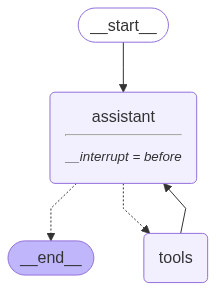

In [92]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [93]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [94]:
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='ac527f42-9f48-47cf-b1d6-5137bc7dfc0a')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f086d92-8218-678c-8000-a5f67af11eab'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-09-01T02:12:48.779642+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f086d92-8212-6292-bfff-9ebe48b1689f'}}, tasks=(PregelTask(id='086143ff-e69c-faff-0a1c-94a73f43a7fd', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [95]:
graph.update_state(
    thread,
    {"messages": [HumanMessage(content="No, actually multiply 3 and 3!")]},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f086d92-fe19-616a-8001-05344dc6f81c'}}

In [96]:
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No, actually multiply 3 and 3!


In [97]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, actually multiply 3 and 3!
================================== Ai Message ==================================
Tool Calls:
  multiply (call_H0QsVwu0smlsp68z10SPzecZ)
 Call ID: call_H0QsVwu0smlsp68z10SPzecZ
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9


In [98]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

9
================================== Ai Message ==================================

The product of 3 and 3 is 9.


# Dynamic Feedback

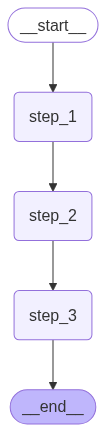

In [99]:
from IPython.display import Image, display

from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt
from langgraph.graph import START, END, StateGraph

class State(TypedDict):
    input: str

def step_1(state: State) -> State:
    print("---Step 1---")
    return state

def step_2(state: State) -> State:
    # Let's optionally raise a NodeInterrupt if the length of the input is longer than 5 characters
    if len(state['input']) > 5:
        raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")
    
    print("---Step 2---")
    return state

def step_3(state: State) -> State:
    print("---Step 3---")
    return state

builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Compile the graph with memory
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [100]:
initial_input = {"input": "hello world"}
thread_config = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello world'}
---Step 1---
{'input': 'hello world'}


/var/folders/xm/hv0x78kx5mvbzd2tsn4q98km0000gn/T/ipykernel_96760/4174644561.py:18: LangGraphDeprecatedSinceV10: NodeInterrupt is deprecated. Please use `langgraph.types.interrupt` instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")


In [101]:
state = graph.get_state(thread_config)
print(state.next)

('step_2',)


In [102]:
print(state.tasks)

(PregelTask(id='12d21560-565f-34c5-78c2-c03ff3302d7d', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(Interrupt(value='Received input that is longer than 5 characters: hello world', id='placeholder-id'),), state=None, result=None),)


In [103]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello world'}


/var/folders/xm/hv0x78kx5mvbzd2tsn4q98km0000gn/T/ipykernel_96760/4174644561.py:18: LangGraphDeprecatedSinceV10: NodeInterrupt is deprecated. Please use `langgraph.types.interrupt` instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")


In [104]:
state = graph.get_state(thread_config)
print(state.next)

('step_2',)


In [105]:
graph.update_state(
    thread_config,
    {"input": "hi"},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f086d97-98a4-6faa-8002-b88fe18c2867'}}

In [106]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'hi'}
---Step 2---
{'input': 'hi'}
---Step 3---
{'input': 'hi'}


# Time Travel

In [107]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

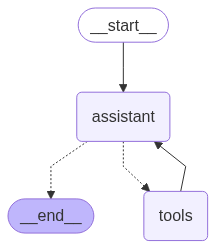

In [108]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [109]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_LCEWDmXyzieRkHLo1wWJG5do)
 Call ID: call_LCEWDmXyzieRkHLo1wWJG5do
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


## Browsing History

In [110]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='dee305dd-e442-4352-ad89-7a1748566188'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_LCEWDmXyzieRkHLo1wWJG5do', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 'total_tokens': 148, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_46bff0e0c8', 'id': 'chatcmpl-CAoNVOK3Vl2GJt2wY1xJfSnna4lk9', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--285879fd-e3ac-467d-93aa-9e22c3976577-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_LCEWDmX

In [111]:
all_states = [s for s in graph.get_state_history(thread)]

In [112]:
len(all_states)

5

In [113]:
all_states[-2]

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='dee305dd-e442-4352-ad89-7a1748566188')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f086d99-f4e9-65a2-8000-e8e8d42e860a'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-09-01T02:16:08.723799+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f086d99-f4e7-6252-bfff-fe49bd4331bf'}}, tasks=(PregelTask(id='63a0947a-cdc4-d163-3a58-c1820d7eacd1', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_LCEWDmXyzieRkHLo1wWJG5do', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 

## Replaying

In [114]:
to_replay = all_states[-2]

In [115]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='dee305dd-e442-4352-ad89-7a1748566188')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f086d99-f4e9-65a2-8000-e8e8d42e860a'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-09-01T02:16:08.723799+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f086d99-f4e7-6252-bfff-fe49bd4331bf'}}, tasks=(PregelTask(id='63a0947a-cdc4-d163-3a58-c1820d7eacd1', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_LCEWDmXyzieRkHLo1wWJG5do', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 

In [116]:
to_replay.values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='dee305dd-e442-4352-ad89-7a1748566188')]}

In [117]:
to_replay.next

('assistant',)

In [118]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f086d99-f4e9-65a2-8000-e8e8d42e860a'}}

In [119]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_MS47bZhuwqExt5dd1gDO8EeR)
 Call ID: call_MS47bZhuwqExt5dd1gDO8EeR
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


## Forking

In [120]:
to_fork = all_states[-2]
to_fork.values["messages"]

[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='dee305dd-e442-4352-ad89-7a1748566188')]

In [121]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f086d99-f4e9-65a2-8000-e8e8d42e860a'}}

In [122]:
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [HumanMessage(content='Multiply 5 and 3', 
                               id=to_fork.values["messages"][0].id)]},
)

In [123]:
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f086dac-c23e-69d2-8001-481e415514a8'}}

In [124]:
all_states = [state for state in graph.get_state_history(thread) ]
all_states[0].values["messages"]

[HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='dee305dd-e442-4352-ad89-7a1748566188')]

In [125]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='dee305dd-e442-4352-ad89-7a1748566188')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f086dac-c23e-69d2-8001-481e415514a8'}}, metadata={'source': 'update', 'step': 1, 'parents': {}}, created_at='2025-09-01T02:24:33.438350+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f086d99-f4e9-65a2-8000-e8e8d42e860a'}}, tasks=(PregelTask(id='8d488882-0fdf-dca2-36c1-eb939434a26f', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [126]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 5 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_p9l2fI7hi0mjnWWR7M1w8yn4)
 Call ID: call_p9l2fI7hi0mjnWWR7M1w8yn4
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================

The result of multiplying 5 and 3 is 15.


In [127]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='dee305dd-e442-4352-ad89-7a1748566188'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_p9l2fI7hi0mjnWWR7M1w8yn4', 'function': {'arguments': '{"a":5,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 'total_tokens': 148, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_46bff0e0c8', 'id': 'chatcmpl-CAoW6vYrHmMFT1XxsDFfhKhkXKrSx', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ea528862-5624-46d5-a3a1-6c671591d93d-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 3}, 'id': 'call_p9l2fI7

# Parallelization

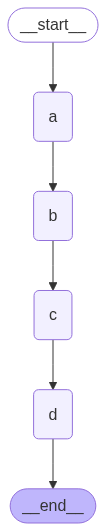

In [128]:
from IPython.display import Image, display

from typing import Any
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: str

class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['state']}")
        return {"state": [self._value]}

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("b", "c")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [129]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm B"]
Adding I'm D to ["I'm C"]


{'state': ["I'm D"]}

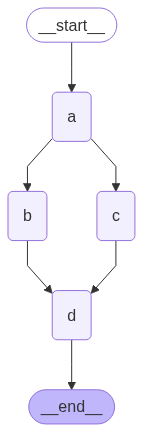

In [130]:
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [131]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"state": []})
except InvalidUpdateError as e:
    print(f"An error occurred: {e}")

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
An error occurred: At key 'state': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


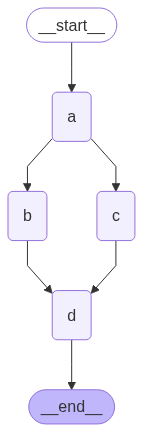

In [132]:
import operator
from typing import Annotated

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: Annotated[list, operator.add]

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

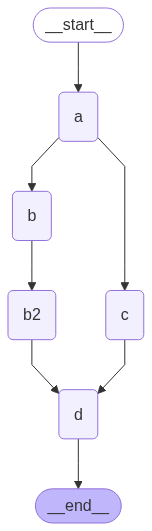

In [133]:
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [134]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm C", "I'm B2"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm D"]}

## Setting the order of state updates

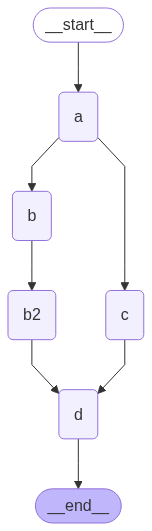

In [135]:
def sorting_reducer(left, right):
    """ Combines and sorts the values in a list"""
    if not isinstance(left, list):
        left = [left]

    if not isinstance(right, list):
        right = [right]
    
    return sorted(left + right, reverse=False)

class State(TypedDict):
    # sorting_reducer will sort the values in state
    state: Annotated[list, sorting_reducer]

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [136]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm B2", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm B2", "I'm C", "I'm D"]}

## Working with LLMs

In [137]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

In [138]:
class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]

In [139]:
import os, getpass
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
_set_env("TAVILY_API_KEY")

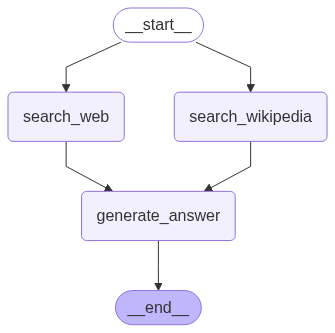

In [143]:
from langchain_core.messages import HumanMessage, SystemMessage

from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools import TavilySearchResults

def search_web(state):
    
    """ Retrieve docs from web search """

    # Search
    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke(state['question'])

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state):
    
    """ Retrieve docs from wikipedia """

    # Search
    search_docs = WikipediaLoader(query=state['question'], 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}">\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def generate_answer(state):
    
    """ Node to answer a question """

    # Get state
    context = state["context"]
    question = state["question"]

    # Template
    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(question=question, 
                                                       context=context)    
    
    # Answer
    answer = llm.invoke([SystemMessage(content=answer_instructions)]+[HumanMessage(content=f"Answer the question.")])
      
    # Append it to state
    return {"answer": answer}

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("search_web",search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)

# Flow
builder.add_edge(START, "search_wikipedia")
builder.add_edge(START, "search_web")
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("generate_answer", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [144]:
result = graph.invoke({"question": "How were Nvidia's Q2 2024 earnings"})
result['answer'].content

"Nvidia's Q2 2024 earnings were very strong. The company reported a record quarterly revenue of $30.0 billion, which was up 15% from the previous quarter and up 122% from a year ago. The data center revenue was also a record at $26.3 billion, up 16% from the previous quarter and up 154% from a year ago. Nvidia's earnings per share were adjusted to 68 cents, beating the estimates of 64 cents. Additionally, Nvidia returned $15.4 billion to shareholders in the form of share repurchases and cash dividends during the first half of fiscal 2025. The Board of Directors also approved an additional $50.0 billion in share repurchase authorization. Overall, Nvidia's Q2 2024 earnings were significantly above expectations and demonstrated strong growth."

# Sub-graph

In [154]:
from operator import add
from typing_extensions import TypedDict
from typing import List, Optional, Annotated

# The structure of the logs
class Log(TypedDict):
    id: str
    question: str
    docs: Optional[List]
    answer: str
    grade: Optional[int]
    grader: Optional[str]
    feedback: Optional[str]

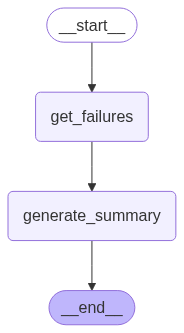

In [155]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Failure Analysis Sub-graph
class FailureAnalysisState(TypedDict):
    cleaned_logs: List[Log]
    failures: List[Log]
    fa_summary: str
    processed_logs: List[str]

class FailureAnalysisOutputState(TypedDict):
    fa_summary: str
    processed_logs: List[str]

def get_failures(state):
    """ Get logs that contain a failure """
    cleaned_logs = state["cleaned_logs"]
    failures = [log for log in cleaned_logs if "grade" in log]
    return {"failures": failures}

def generate_summary(state):
    """ Generate summary of failures """
    failures = state["failures"]
    # Add fxn: fa_summary = summarize(failures)
    fa_summary = "Poor quality retrieval of Chroma documentation."
    return {"fa_summary": fa_summary, "processed_logs": [f"failure-analysis-on-log-{failure['id']}" for failure in failures]}

fa_builder = StateGraph(state_schema=FailureAnalysisState,output_schema=FailureAnalysisOutputState)
fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("generate_summary", generate_summary)
fa_builder.add_edge(START, "get_failures")
fa_builder.add_edge("get_failures", "generate_summary")
fa_builder.add_edge("generate_summary", END)

graph = fa_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

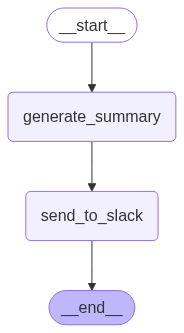

In [156]:
# Summarization subgraph
class QuestionSummarizationState(TypedDict):
    cleaned_logs: List[Log]
    qs_summary: str
    report: str
    processed_logs: List[str]

class QuestionSummarizationOutputState(TypedDict):
    report: str
    processed_logs: List[str]

def generate_summary(state):
    cleaned_logs = state["cleaned_logs"]
    # Add fxn: summary = summarize(generate_summary)
    summary = "Questions focused on usage of ChatOllama and Chroma vector store."
    return {"qs_summary": summary, "processed_logs": [f"summary-on-log-{log['id']}" for log in cleaned_logs]}

def send_to_slack(state):
    qs_summary = state["qs_summary"]
    # Add fxn: report = report_generation(qs_summary)
    report = "foo bar baz"
    return {"report": report}

qs_builder = StateGraph(QuestionSummarizationState,output_schema=QuestionSummarizationOutputState)
qs_builder.add_node("generate_summary", generate_summary)
qs_builder.add_node("send_to_slack", send_to_slack)
qs_builder.add_edge(START, "generate_summary")
qs_builder.add_edge("generate_summary", "send_to_slack")
qs_builder.add_edge("send_to_slack", END)

graph = qs_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [157]:
# Entry Graph
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: Annotated[List[Log], add] # This will be USED BY in BOTH sub-graphs
    fa_summary: str # This will only be generated in the FA sub-graph
    report: str # This will only be generated in the QS sub-graph
    processed_logs:  Annotated[List[int], add] # This will be generated in BOTH sub-graphs

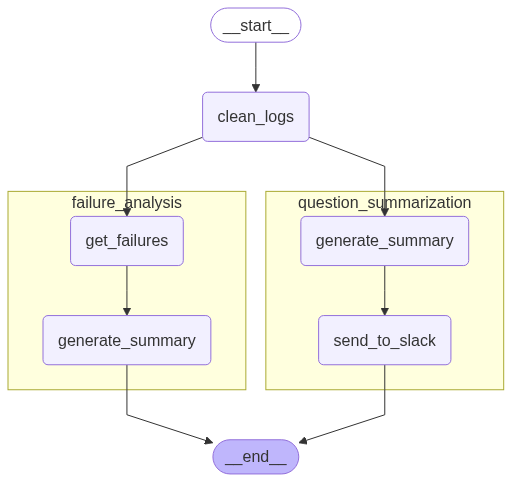

In [158]:
# Entry Graph
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: List[Log]
    fa_summary: str # This will only be generated in the FA sub-graph
    report: str # This will only be generated in the QS sub-graph
    processed_logs:  Annotated[List[int], add] # This will be generated in BOTH sub-graphs

def clean_logs(state):
    # Get logs
    raw_logs = state["raw_logs"]
    # Data cleaning raw_logs -> docs 
    cleaned_logs = raw_logs
    return {"cleaned_logs": cleaned_logs}

entry_builder = StateGraph(EntryGraphState)
entry_builder.add_node("clean_logs", clean_logs)
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())

entry_builder.add_edge(START, "clean_logs")
entry_builder.add_edge("clean_logs", "failure_analysis")
entry_builder.add_edge("clean_logs", "question_summarization")
entry_builder.add_edge("failure_analysis", END)
entry_builder.add_edge("question_summarization", END)

graph = entry_builder.compile()

from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [159]:
# Dummy logs
question_answer = Log(
    id="1",
    question="How can I import ChatOllama?",
    answer="To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'",
)

question_answer_feedback = Log(
    id="2",
    question="How can I use Chroma vector store?",
    answer="To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).",
    grade=0,
    grader="Document Relevance Recall",
    feedback="The retrieved documents discuss vector stores in general, but not Chroma specifically",
)

raw_logs = [question_answer,question_answer_feedback]
graph.invoke({"raw_logs": raw_logs})

{'raw_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, but not Chroma specifically'}],
 'cleaned_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, 

# Map-Reduce

In [145]:
from langchain_openai import ChatOpenAI

# Prompts we will use
subjects_prompt = """Generate a list of 3 sub-topics that are all related to this overall topic: {topic}."""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one, starting 0 as the ID for the first joke. Jokes: \n\n  {jokes}"""

# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0) 

## State

In [146]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel

class Subjects(BaseModel):
    subjects: list[str]

class BestJoke(BaseModel):
    id: int
    
class OverallState(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list, operator.add]
    best_selected_joke: str

In [147]:
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}

In [148]:
from langgraph.types import Send
def continue_to_jokes(state: OverallState):
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]

## Map

In [149]:
class JokeState(TypedDict):
    subject: str

class Joke(BaseModel):
    joke: str

def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}

## Reduce

In [151]:
def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}

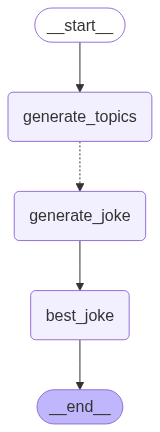

In [152]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)

# Compile the graph
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())

In [153]:
# Call the graph: here we call it to generate a list of jokes
for s in app.stream({"topic": "animals"}):
    print(s)

{'generate_topics': {'subjects': ['Animal Behavior and Communication', 'Conservation and Endangered Species', 'Animal Habitats and Ecosystems']}}
{'generate_joke': {'jokes': ['Why did the parrot bring a ladder to the conversation?\n\nBecause it wanted to take the dialogue to new heights!']}}
{'generate_joke': {'jokes': ['Why did the squirrel bring a suitcase to the forest?\n\nBecause it heard the ecosystem was "tree-mendous" and wanted to branch out!']}}
{'generate_joke': {'jokes': ['Why did the endangered species start a band?\n\nBecause they wanted to make some noise before they went extinct!']}}
{'best_joke': {'best_selected_joke': 'Why did the parrot bring a ladder to the conversation?\n\nBecause it wanted to take the dialogue to new heights!'}}


# Research Assistant